## Compile statistics from text files

The code below is used to capture a number of data points from the OCRd text files that can be used to detect patterns and classify the documents into bins that require different processing workflows.


### Setup

In [1]:
import csv
import os
import regex as re # https://pypi.org/project/regex/
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from ipywidgets import IntProgress
from IPython.display import display

plt.style.use(['dark_background'])
InteractiveShell.ast_node_interactivity = "none"
pd.options.display.max_rows = 100


In [2]:
# progress bar
def p_bar(mx, desc):
    global p
    p = IntProgress(min=0, max=mx, description=desc)
    return p

# paths
english_dict_path = 'data/nltk_english_words'  # path to dictionary of all English words

# production:
raw_text_path = 'data/raw_text/'
save_data_path = 'data/'

# testing:
#raw_text_path = 'test_data/sample/'
#save_data_path = 'test_data/'

# patterns 
ascii_string = set("""!"#$%&\'()*+,-./0123456789:; =?ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]_`abcdefghijklmnopqrstuvwxyz""")
word_chars = re.compile("[^a-zA-Z0-9 -']")

# load English dictionary
with open(english_dict_path, 'r') as file:
    english_words = set(file.read().split('\n'))

# create a list of all files in the folder
raw_files = [f'{raw_text_path}{file.name}' for file in os.scandir(raw_text_path) if file.name != ".DS_Store"]


### Extract statistics

In [3]:
file_stats = {}  # dictionary to store the results
display(p_bar(len(raw_files), 'Processing')) # show the progress bar

for i, fpath in enumerate(raw_files):
    with open(fpath, 'r') as file:
        text = file.read()
    
    # determine presence of "JOINT RESOLUTION" string
    # fuzzy match parmitting 3 errors, ie. subs|dels|ins
    jt_matches = re.search('(JOINT RESOLUTION){e<=3}', text)
    
    line_count = len(text.split('\n')) # number of lines
    char_count = len(text)  # number of characters
    ascii_count = sum(c in ascii_string for c in text)  # percent of ascii characters
    
    text = word_chars.sub('', text) # clean non-word characters
    tokens = [w.lower() for w in text.split(' ')]  # tokenize
    word_count = len(tokens)  # number of words
    english_count = sum(c in english_words for c in tokens)  # percent of english words
    
    # add metrics to dict
    filename = os.path.basename(fpath)  # get filename
    file_stats[filename] = {
        'lines': line_count,
        'chars': char_count,
        'words': ascii_count,
        'ascii_chars': round(ascii_count*100/char_count, 2),
        'english_words': round(english_count*100/word_count, 2),
        'jt_string': 1 if jt_matches is not None else 0
    }
    
    if i % 100 == 0:
        p.value += 100  #update progress bar


IntProgress(value=0, description='Processing', max=9838)

In [4]:
file_stats_df = pd.DataFrame.from_dict(file_stats, orient='index')  # create a dataframe with the results
file_stats_df.to_csv(f'{save_data_path}text_file_statistics.csv')  # save the results to a CSV file

display(file_stats_df)  # display the results


,lines,chars,words,ascii_chars,english_words,jt_string
91-hjres1029-000ih-19691209.txt,27,1269,1218,95.98,70.11,0
94-hjres272-000ih-19750304.txt,28,1180,1132,95.93,70.55,1
90-hjres1137-000ih-19680227.txt,25,1076,1034,96.10,72.33,1
78-hjres318-000ih-19441128.txt,40,1278,1218,95.31,70.86,1
92-sjres34-000is-19710126.txt,40,1990,1936,97.29,60.36,0
...,...,...,...,...,...,...
101-sjres9-000is-19890125.txt,68,2220,2133,96.08,71.70,1
bills-106hjres3ih.txt,32,1164,1115,95.79,68.42,1
88-hjres28-000ih-19630109.txt,209,6057,5814,95.99,78.44,1
bills-104hjres11ih.txt,159,4546,4361,95.93,74.81,1


### Analysis

In [5]:
# show descriptive stats for key metrics
display(file_stats_df.describe()[
    ['lines', 'chars', 'words', 'ascii_chars', 'english_words']
])


,lines,chars,words,ascii_chars,english_words
count,9838.000000,9.838000e+03,9.838000e+03,9838.000000,9838.000000
mean,133.252185,4.038591e+03,3.860114e+03,95.624264,72.176338
std,1860.356820,4.956045e+04,4.723138e+04,1.689870,4.865600
min,1.000000,1.000000e+00,0.000000e+00,0.000000,15.710000
25%,33.000000,1.309000e+03,1.253000e+03,95.550000,70.470000
50%,49.000000,1.578000e+03,1.510000e+03,95.950000,72.680000
75%,74.000000,2.325000e+03,2.222750e+03,96.230000,75.000000
max,109758.000000,2.764147e+06,2.638264e+06,97.850000,100.000000


The mean for ```english_words``` is 72.2 while the ```min``` is 15.7, the outliers should correspond to the handwritten documents where the OCR engine returns just gibberish. We can confirm with a quick chart:

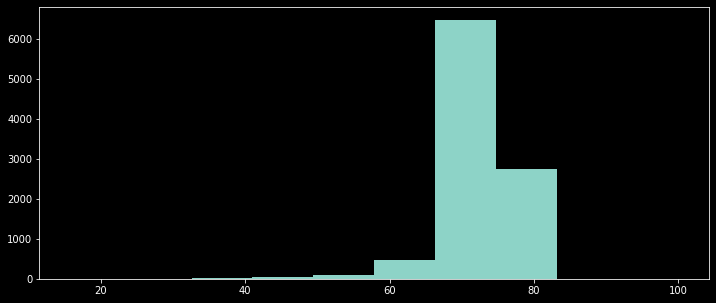

In [6]:
fig = plt.figure(figsize=(12, 5))
plt.hist(file_stats_df['english_words'])


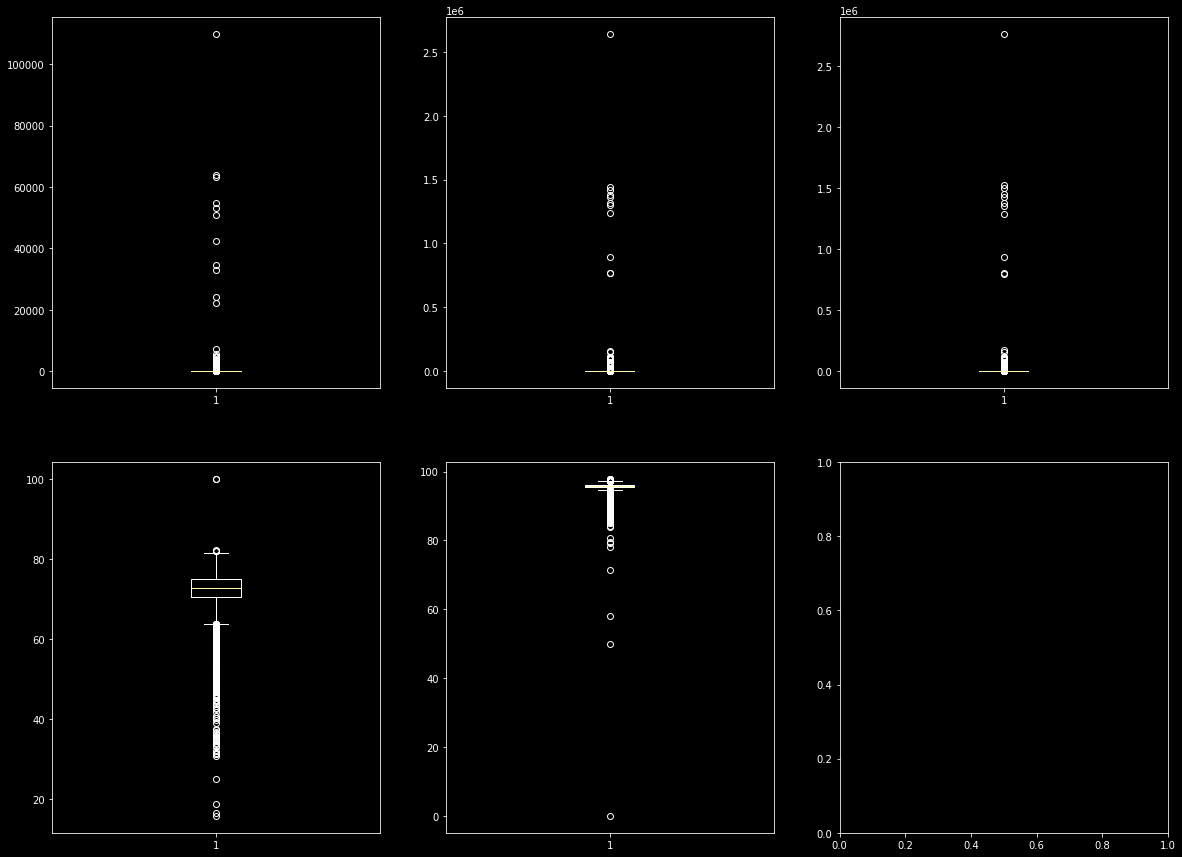

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(20, 15))
axs[0, 0].boxplot(file_stats_df['lines'])
axs[0, 1].boxplot(file_stats_df['words'])
axs[0, 2].boxplot(file_stats_df['chars'])
axs[1, 0].boxplot(file_stats_df['english_words'])
axs[1, 1].boxplot(file_stats_df['ascii_chars'])


